In [3]:
#############
###paths#####
#############
import sys
import os

pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1] 
sys.path.append(modellingpath + '/lib')
#############
import pickle as pkl
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from equations.class_subcircuit_eq import *
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [16]:
def plotDoseResponse2(inducer,doseResponseRed, doseResponseGreen,semRed, semGreen, pad=0.01, inducerName = '[OC14]'):
    fig,ax = plt.subplots()

    ax.plot(inducer,doseResponseRed,label='RFP', c='red')
    ax.errorbar(inducer,doseResponseRed,yerr=semRed,c='red',fmt='o')
    ax.legend(loc='center left') #upper right
    # ax.ticklabel_format(useOffset=False)
    ax.set_xscale('log')
    ax.set_xlabel(inducerName)
    ax.set_ylim(0,np.amax(doseResponseRed)*1.1)
    ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$')
    ax2=ax.twinx()
    ax2.plot(inducer,doseResponseGreen,label='GFP', c='green')
    ax2.errorbar(inducer,doseResponseGreen,yerr=semGreen,c='green',fmt='o')
    ax2.legend(loc='center right') #upper left
    # ax2.ticklabel_format(useOffset=False)
    ax.set_xscale('log')
    ax2.set_xlabel(inducerName)
    ax2.set_ylim(0,np.amax(doseResponseGreen)*1.1)
    ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$')

    plt.show()
def plotDoseResponsevsData(inducer,inducer_continuous, rfpExp_list, gfpExp_list, semRed, semGreen, doseResponseRed,doseResponseGreen,pad=0.01):
    fig,ax = plt.subplots()

    ax.plot(inducer_continuous,doseResponseRed,label='RFP', c='red')
    ax.scatter(inducer,rfpExp_list, c='red')
    ax.errorbar(inducer,rfpExp_list,yerr=semRed,c='red',fmt='o')
    ax.legend(loc='center left') #upper right
    # ax.ticklabel_format(useOffset=False)
    ax.set_xscale('log')


    ax2=ax.twinx()
    ax2.plot(inducer_continuous,doseResponseGreen,label='GFP', c='green')
    ax2.scatter(inducer,gfpExp_list, c='green')
    ax2.errorbar(inducer,gfpExp_list,yerr=semGreen,c='green',fmt='o')
    ax2.legend(loc='center right') #upper left
    # ax2.ticklabel_format(useOffset=False)
    ax.set_xscale('log')


    plt.show()

def plotDoseResponse(inducer_list, U_ss, color='k'):
    plt.plot(inducer_list,U_ss, c=color)
    plt.xlabel('[inducer]')
    plt.ylabel('Fluorescence')
    plt.xscale('log')
    plt.show()

def doseResponse(subcircuit, inducer_list, initial_conditions=[10,10]):
    U_ss = []
    T=1000
    t = np.linspace(0, T, T*50)
    for inducer in inducer_list:
        sol = odeint(subcircuit.ddt, initial_conditions, t, args=(inducer,inducer))
        Ustar_ODE=sol[-1]
        U_ss.append(sol[-1])
    return np.array(U_ss)

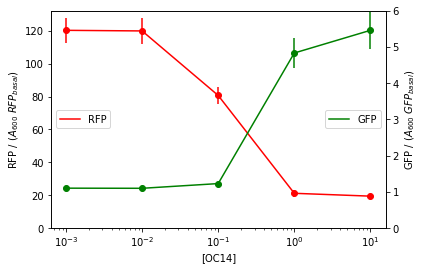

array([1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [5]:
doseResponseExp = pkl.load(open('input/subcircuit1_circuit14_doseResponse_maxATC.pkl','rb'))
AHL_list = doseResponseExp['AHL_list']; gfpExp_list = doseResponseExp['maxATC_doseResponse_gfp']; rfpExp_list = doseResponseExp['maxATC_doseResponse_rfp']
semRed = doseResponseExp['maxATC_doseResponse_rfp_sem']; semGreen = doseResponseExp['maxATC_doseResponse_gfp_sem']


plotDoseResponse2(AHL_list, rfpExp_list, gfpExp_list, semRed, semGreen)
AHL_list

# ABC Steps
Step 1: load parameter distributions (prior)\
Step 2: Sample from prior\
Step 3: Compare samples to ExpData with measure and select with threshold\
Step 4: Resample from chosen samples distribution and reduce threshold\
Step 5: 

Step 1: load parameter distributions (prior)


In [6]:

# Specify name of circuit and variant investigated
circuit_n='circuit14'
variant='1nd'
# Specifiy number of parameter sets in parameterset file to be loaded
n_param_sets = 1000000

print(f'Circuit:{circuit_n}, Variant:{variant}')

df_full= pkl.load( open(modellingpath + "/3954/paper/input/balanced_parameterfiles/df_%s_variant%s_%rparametersets_balanced.pkl"%(circuit_n,variant,n_param_sets), "rb"))
df = df_full[['VE','VF','muLVA','Kbd','Kfe','nbd','nfe','Kee','nee']]
df_balanced = df_full[df_full['balance'] == 'Balanced']
df_balanced

Circuit:circuit14, Variant:1nd


,Dr,VA,VB,VC,VD,VE,VF,Kda,Kab,Keb,...,muLVA,muASV,nbd,nab,nda,nfe,nee,neb,nce,balance
0,0.143023,52.840864,797.836313,19.177823,47.425968,98.603756,702.461106,30.246197,32.166023,5.117991,...,3.394454,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
1,0.045471,100.575081,145.183479,304.345002,135.452353,155.554552,999.253725,48.591258,31.697148,39.976130,...,3.414466,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
2,1.257643,93.554350,292.385504,348.703942,475.522215,41.532850,301.720176,6.484979,3.660737,2.094126,...,3.938688,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
3,24.275399,38.600819,383.005511,154.001815,63.448029,267.681731,281.612052,34.344444,7.448186,53.779745,...,3.228803,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
4,0.052086,110.427113,423.692866,694.379864,350.477990,87.049174,444.717315,44.820783,11.087726,3.832140,...,3.310359,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,4.962207,639.202628,366.522719,743.197069,182.621554,959.542199,327.439791,2.685110,194.205683,69.751969,...,3.878041,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
999996,2.556228,33.051327,259.428504,758.420601,332.519335,388.291530,321.379872,80.385326,10.710191,25.301305,...,4.300639,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
999997,0.010673,46.453480,190.194855,77.261856,22.972700,33.243426,22.027648,8.978784,22.976506,1.349458,...,3.529508,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced
999998,90.051557,665.062788,640.143808,369.248901,45.690058,289.991435,52.842083,27.775923,5.625633,111.584325,...,4.223485,1.0,2.0,1.0,1.0,4.0,4.0,4.0,1.0,Balanced


In [ ]:
AHL_list
A_list = np.logspace(1,-3, 5)
AHL_list, A_list

(array([1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03]),
 array([1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03]))

0
[0.001184173493273223, 0.12196223274183454]


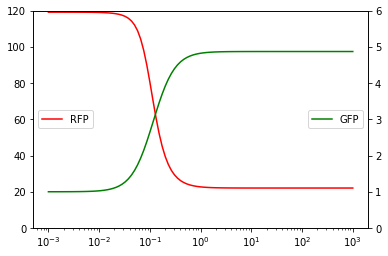

------------------
1
[0.024793069148248654, 0.45081237422189346]


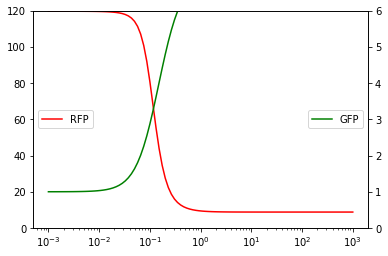

------------------
2
[0.0025761223353169774, 0.13457563348424842]


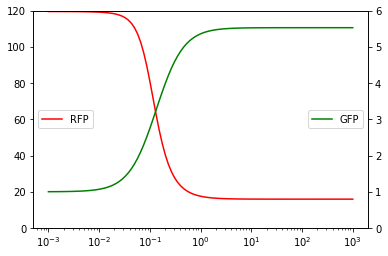

------------------
3
[0.14821540827711288, 0.005200637374927208]


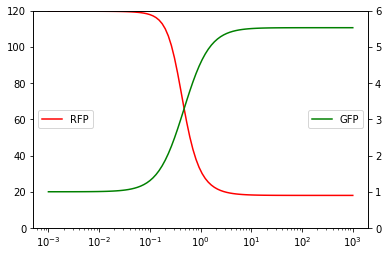

------------------
4
[2.1674474501606267, 0.005200637374927208]


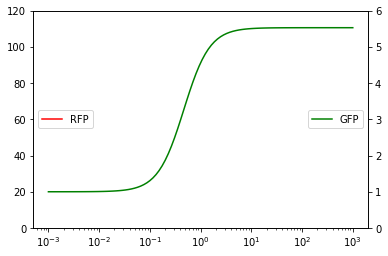

------------------
5
[3.524878986382944, 0.005200637374927208]


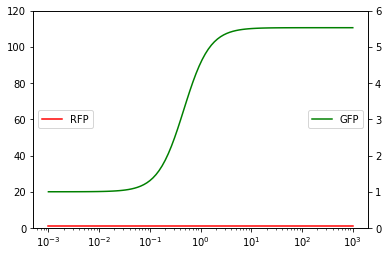

------------------


In [17]:
A_list = np.logspace(1,-3, 100)
subcircuit = lambda x: subcircuit1_circuit14(x)
data = np.array([rfpExp_list, gfpExp_list]).T
sem = np.array([semRed, semGreen])

good_pardict1 =  {'VE': 119.85647811297729, 'VF': 3.8699084144591938, 'muLVA': 3.5033760524902595, 'Kbd': 0.11606253243374419, 'Kfe': 3.185800471010359, 'Kee': 0.09999996710575525, 'nbd': 2.0344787561289177, 'nfe': 3.6425482727920606, 'nee': 4.000000008760399}

good_pardict2 =  {'VE': 119.72143284611407, 'VF': 5.940100490421818, 'muLVA': 3.503375965926921, 'Kbd': 0.1497382604896311, 'Kfe': 3.441357464274913, 'Kee': 0.09999999708037076, 'nbd': 1.9307152161207934, 'nfe': 3.798016814688695, 'nee': 4.000000000577716}

good_pardict3 =  {'VE': 119.76207777030659, 'VF': 4.527366973484433, 'muLVA': 3.5033759643560813, 'Kbd': 0.1332581611749327, 'Kfe': 3.3050693126868755, 'Kee': 0.10000000063868318, 'nbd': 1.611445073705572, 'nfe': 3.7916010317166737, 'nee': 3.9999999988000687}

good_pardict4 = {'VE': 119.72143284611407, 'VF': 4.527080750371472, 'muLVA': 3.503375965926921, 'Kbd': 0.4661989090307794, 'Kfe': 3.441357464274913, 'Kee': 0.09999999708037076, 'nbd': 1.7024856417737533, 'nfe': 3.798016814688695, 'nee': 4.000000000577716}
good_pardict5 = {'VE': 119.72143284611407, 'VF': 4.527080750371472, 'muLVA': 3.503375965926921, 'Kbd': 0.4661989090307794, 'Kfe': 1000, 'Kee': 0.09999999708037076, 'nbd': 1.7024856417737533, 'nfe': 3.798016814688695, 'nee': 4.000000000577716}
good_pardict6 = {'VE': 119.72143284611407, 'VF': 4.527080750371472, 'muLVA': 3.503375965926921, 'Kbd': 0.4661989090307794, 'Kfe': 3.441357464274913, 'Kee': 1000, 'nbd': 1.7024856417737533, 'nfe': 3.798016814688695, 'nee': 4.000000000577716}

# good_pardict5 =  {'VE': 120, 'VF': 3.5, 'muLVA': 3.5033759791093995, 'Kbd': 0.5, 'Kfe': 5, 'Kee': 0.1, 'nbd': 2, 'nfe': 4.0, 'nee': 4.0}

# good_pardict6 =  {'VE': 120, 'VF': 6, 'muLVA': 3.5033759791093995, 'Kbd': 0.9, 'Kfe': 5, 'Kee': 0.1, 'nbd': 2.0, 'nfe': 4.0, 'nee': 4.0}

par_list = [good_pardict1, good_pardict2, good_pardict3, good_pardict4, good_pardict5, good_pardict6]
for count, par_dict in enumerate(par_list):
    print(count)
    A_list = np.logspace(1,-3, 100)
    U_ss= doseResponse(subcircuit(par_dict), AHL_list)
    Vmax_list = [np.max(data[:,x]) for x in range(2)]
    mean_list = [np.mean(data[:,x]) for x in range(2)]
    # relError = [np.sum(np.square((U_ss - data)[:,x]/mean_list[x])) for x in range(2)]
    # relError = [np.sum(np.square(U_ss - data)[:,x]/sem) for x in range(2)]
    # relError = [np.sum(np.square((U_ss - data)[:,x]/Vmax_list[x])) for x in range(2)]
    relError = [np.sum(np.square(data - U_ss)[:,x])/np.sum(np.square(data[:,x] - mean_list[x])) for x in range(2)]
    print(relError)
    A_list = np.logspace(3,-3, 100)
    U_ss_continuous= doseResponse(subcircuit(par_dict), A_list)
    plotDoseResponsevsData(AHL_list,A_list,rfpExp_list,gfpExp_list,semRed, semGreen,  U_ss_continuous[:,0] ,U_ss_continuous[:,1] )

    print('------------------')

Step 2: Sample from prior


In [ ]:
Vmax_list

[120.26952911563737, 5.4555320840801516]

In [ ]:
def rse():
    return  (np.square(U_ss - data))/()

In [ ]:
A_list = np.logspace(1,-3, 100)
subcircuit = lambda x: subcircuit1_circuit14(x)
data = np.array([rfpExp_list, gfpExp_list]).T
sem = np.array([semRed, semGreen])

for parID in tqdm(df_balanced.index):
    A_list = np.logspace(1,-3, 100)
    par_dict = df.loc[parID].to_dict()
    U_ss= doseResponse(subcircuit(par_dict), AHL_list)
    Vmax_list = [np.max(data[:,x]) for x in range(2)]
    # relError = [np.sum(np.square((U_ss - data)[:,x]/Vmax_list[x])) for x in range(2)]
    # relError = [np.sum(np.square(U_ss - data)[:,x]/sem) for x in range(2)]
    mean_list = [np.mean(data[:,x]) for x in range(2)]
    relError = [np.sum(np.square(data - U_ss)[:,x])/np.sum(np.square(data[:,x] - mean_list[x])) for x in range(2)]
    if relError[0]<0.5 and relError[1]<0.5:
        print(relError)
        print(par_dict)
        A_list = np.logspace(3,-3, 100)
        U_ss_continuous= doseResponse(subcircuit(par_dict), A_list)
        plotDoseResponsevsData(AHL_list,A_list,rfpExp_list,gfpExp_list,semRed, semGreen,  U_ss_continuous[:,0] ,U_ss_continuous[:,1] )

        print('------------------')



  0%|          | 3535/1000000 [00:52<4:07:40, 67.06it/s]


KeyboardInterrupt: 

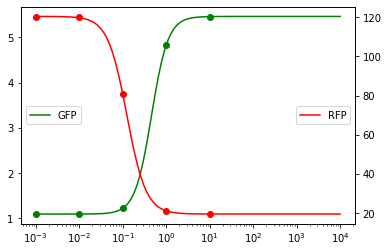

  0%|          | 0/10 [00:00<?, ?it/s]

[0.1838095884139507, 43.16163652402461]


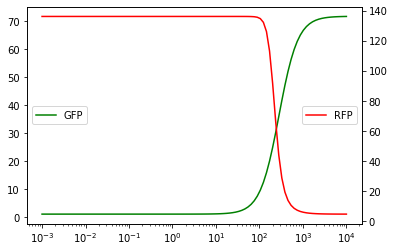

 10%|█         | 1/10 [00:00<00:06,  1.34it/s]

[0.1838095884139507, 43.16163652402461]


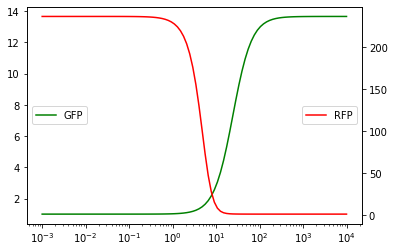

 20%|██        | 2/10 [00:01<00:06,  1.31it/s]

[0.1838095884139507, 43.16163652402461]


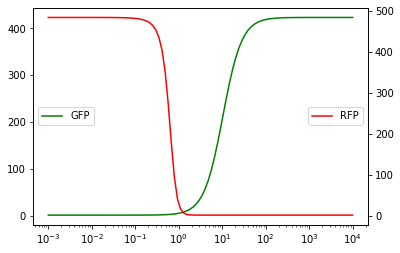

 30%|███       | 3/10 [00:02<00:05,  1.33it/s]

[0.1838095884139507, 43.16163652402461]


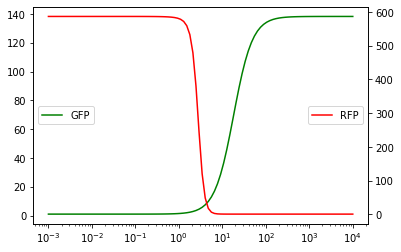

 40%|████      | 4/10 [00:03<00:04,  1.30it/s]

[0.1838095884139507, 43.16163652402461]


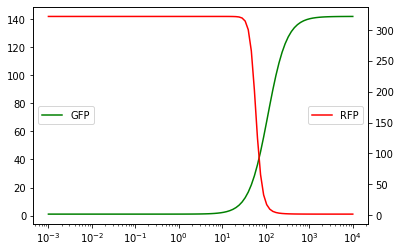

 50%|█████     | 5/10 [00:03<00:03,  1.32it/s]

[0.1838095884139507, 43.16163652402461]


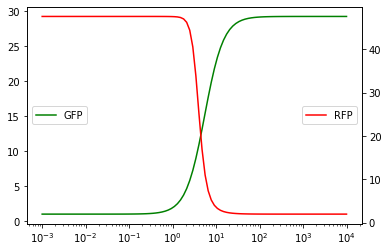

 60%|██████    | 6/10 [00:04<00:03,  1.32it/s]

[0.1838095884139507, 43.16163652402461]


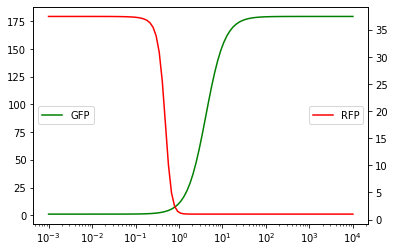

 70%|███████   | 7/10 [00:05<00:02,  1.33it/s]

[0.1838095884139507, 43.16163652402461]


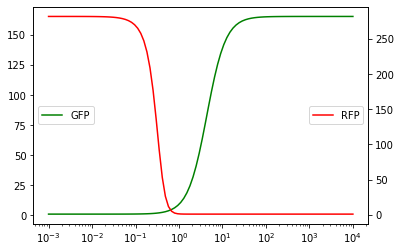

 80%|████████  | 8/10 [00:06<00:01,  1.28it/s]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
A_list = np.logspace(-3,1, 100)

fig,ax = plt.subplots()
# ax.ticklabel_format(style='plain')      
ax.plot(A_list,gfpFit,label='GFP', c='green')
ax.scatter(AHL_list, gfpExp_list, c='green')
ax.legend(loc='center left') #upper left
ax.ticklabel_format(useOffset=False)

ax2=ax.twinx()
ax2.plot(A_list,rfpFit,label='RFP', c='red')
ax2.scatter(AHL_list, rfpExp_list, c='red')
ax2.legend(loc='center right') #upper right

ax2.ticklabel_format(useOffset=False)
ax.set_xscale('log')
plt.show()
for parID in tqdm(df_balanced.index[:10]):
    par_dict = df.loc[parID].to_dict()
    # par_dict['Kee'] = 0.1
    # U_ss= doseResponse(subcircuit(par_dict), A_list)
    # plotDoseResponse2(A_list,U_ss[:,2], U_ss[:,1] )
    # mse = [mean_squared_error(U_ss[:,1], gfpFit), mean_squared_error(U_ss[:,0], rfpFit)]
    # mse = [mean_squared_error(gfpFit*0.9, gfpFit), mean_squared_error(rfpFit*0.9, rfpFit)]
    # print(mean_squared_error(U_ss[:,1], gfpFit), mean_squared_error(U_ss[:,0], rfpFit))
    print(mse)
    # if mse[1]<10 and mse[0]<10:
    # print(par_dict)
    # if mse<10:
    plotDoseResponsevsData(AHL_list,A_list,rfpExp_list,gfpExp_list,semRed, semGreen,  U_ss[:,0] ,U_ss[:,1] )

    plotDoseResponse2(A_list,U_ss[:,1], U_ss[:,0] )
    # print('minmin', np.amin(U_ss[:,1]), np.amin(U_ss[:,0]))
    # print('maxmax', np.amax(U_ss[:,1]), np.amax(U_ss[:,0]))
    # print(par_dict['VF'], par_dict['VE'])
    # print('-------')
